In [7]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import itertools
from collections import OrderedDict

def add_summary(data, with_as=False):
    """
    Add summary stats to a dataframe
    """
    e = "as_" if with_as else ""
    data['Total Calls'] = data[['Concordant', 'Discordant', 'Missing', 'Filtered']].sum(axis=1)
    data['Total Genotyped'] = data['Total Calls'] - data['Missing']
    data['Missing Rate'] = data['Missing'] / data['Total Genotyped']
    data['GT Concordance'] = data['Concordant'] / data['Total Genotyped']
    data[f'{e}compP'] = data[f'{e}TP'] + data[f'{e}FP']
    data[f'{e}baseP'] = data[f'{e}TP'] + data[f'{e}FN']
    data[f'{e}compN'] = data[f'{e}TN'] + data[f'{e}FN']
    data[f'{e}baseN'] = data[f'{e}TN'] + data[f'{e}FP']
    data[f'{e}ppv'] = data[f'{e}TP'] / data[f'{e}compP']
    data[f'{e}tpr'] = data[f'{e}TP'] / data[f'{e}baseP']
    data[f'{e}tnr'] = data[f'{e}TN'] / data[f'{e}baseN']
    data[f'{e}npv'] = data[f'{e}TN'] / data[f'{e}compN']
    data[f'{e}acc'] = (data[f'{e}TP'] + data[f'{e}TN']) / (data[f'{e}baseP'] + data[f'{e}baseN'])
    data[f'{e}ba'] = (data[f'{e}tpr'] + data[f'{e}tnr']) / 2
    data[f'{e}f1'] = 2 * ((data[f'{e}ppv'] * data[f'{e}tpr']) / (data[f'{e}ppv'] + data[f'{e}tpr']))
    
    
gt_data = pd.read_csv("../results/tables/all.gt_dist.table.txt", sep='\t')
inter_data = pd.read_csv("../results/tables/all.intersect.table.txt", sep='\t')
neigh_data = pd.read_csv("../results/tables/all.neighbor.table.txt", sep='\t')
svtype_data = pd.read_csv("../results/tables/all.svtype.table.txt", sep='\t')

tr_gt_data = pd.read_csv("../results/tables/tr.gt_dist.table.txt", sep='\t')
tr_inter_data = pd.read_csv("../results/tables/tr.intersect.table.txt", sep='\t')
tr_neigh_data = pd.read_csv("../results/tables/tr.neighbor.table.txt", sep='\t')
tr_svtype_data = pd.read_csv("../results/tables/tr.svtype.table.txt", sep='\t')

ntr_gt_data = pd.read_csv("../results/tables/non_tr.gt_dist.table.txt", sep='\t')
ntr_inter_data = pd.read_csv("../results/tables/non_tr.intersect.table.txt", sep='\t')
ntr_neigh_data = pd.read_csv("../results/tables/non_tr.neighbor.table.txt", sep='\t')
ntr_svtype_data = pd.read_csv("../results/tables/non_tr.svtype.table.txt", sep='\t')

On average, kanpig’s genotype concordance on the 32x coverage experiments was 0.85 compared to 0.762 for svjedi, and 0.781 for cuteSV. Since sniffles was used to discover the SVs, we measure both its original discovery genotypes as well as its force-genotyping modes’ performance separately at 0.805 and 0.804, respectively. 

In [ ]:
view = inter_data[(inter_data['experiment'] == 'ds') &
                 (inter_data['coverage'] == '32x')]

view.groupby(['program'])[['gt_concordance']].mean()


,gt_concordance
program,
cutesv,0.781145
kanpig,0.850740
orig,0.805352
sniffles,0.804316
svjedi,0.762801


 (full strat sup table?)

In [28]:
# Full stratification sup table
add_summary(svtype_data)
add_summary(tr_svtype_data)
add_summary(ntr_svtype_data)

a = svtype_data[(svtype_data['experiment'] == 'ds')].copy()
a['TR'] = 'all'

b = tr_svtype_data[(tr_svtype_data['experiment'] == 'ds')].copy()
b['TR'] = 'within'

c = ntr_svtype_data[(ntr_svtype_data['experiment'] == 'ds')].copy()
c['TR'] = 'outside'

view = pd.concat([a, b, c])
sup_table = (view.groupby(['program', 'coverage', 'svtype', 'TR'])['GT Concordance'].describe()[['mean', 'std']].reset_index())
sup_table.to_csv("SupTable_DS_GTconcordance.txt", sep='\t', index=False)

In [44]:
view = inter_data[(inter_data['experiment'] == 'ds')
                  & ((inter_data['program'] != "orig") | (inter_data['coverage'] == '32x'))
                 ]
view2 = view.groupby(['program', 'coverage'])[['gt_concordance', 'TP-base', 'TP-comp', 'FN', 'FP', 'precision', 'recall', 'f1']].mean()
o = view2.loc[('orig', '32x')]
t = view2.reset_index()
g = t[t['coverage'] == '32x'].set_index(['program', 'coverage'])
diff = g - o
diff

,,gt_concordance,TP-base,TP-comp,FN,FP,precision,recall,f1
program,coverage,,,,,,,,
cutesv,32x,-0.024206,-723.914894,-745.808511,631.489362,-50.872340,0.001536,-0.028023,-0.013964
kanpig,32x,0.045388,-760.297872,-205.638298,914.765957,-51.957447,0.002317,-0.039303,-0.019597
orig,32x,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sniffles,32x,-0.001036,-79.255319,-87.340426,516.361702,-23.042553,0.001025,-0.021185,-0.010550
svjedi,32x,-0.042551,-647.789598,-633.661939,6.413712,63.033097,-0.004181,-0.002025,-0.003071


In [71]:
view2.reset_index().to_csv("SupTable_DS_PrecisionRecall.txt", sep='\t', index=False)

# Sup: DS Overview

In [11]:

def add_summary(data, with_as=False):
    """
    Add summary stats to a dataframe
    """
    e = "as_" if with_as else ""
    data['Total Calls'] = data[['Concordant', 'Discordant', 'Missing', 'Filtered']].sum(axis=1)
    data['Total Genotyped'] = data['Total Calls'] - data['Missing']
    data['Missing Rate'] = data['Missing'] / data['Total Genotyped']
    data['GT Concordance'] = data['Concordant'] / data['Total Genotyped']
    data[f'{e}compP'] = data[f'{e}TP'] + data[f'{e}FP']
    data[f'{e}baseP'] = data[f'{e}TP'] + data[f'{e}FN']
    data[f'{e}compN'] = data[f'{e}TN'] + data[f'{e}FN']
    data[f'{e}baseN'] = data[f'{e}TN'] + data[f'{e}FP']
    data[f'{e}ppv'] = data[f'{e}TP'] / data[f'{e}compP']
    data[f'{e}tpr'] = data[f'{e}TP'] / data[f'{e}baseP']
    data[f'{e}tnr'] = data[f'{e}TN'] / data[f'{e}baseN']
    data[f'{e}npv'] = data[f'{e}TN'] / data[f'{e}compN']
    data[f'{e}acc'] = (data[f'{e}TP'] + data[f'{e}TN']) / (data[f'{e}baseP'] + data[f'{e}baseN'])
    data[f'{e}ba'] = (data[f'{e}tpr'] + data[f'{e}tnr']) / 2
    data[f'{e}f1'] = 2 * ((data[f'{e}ppv'] * data[f'{e}tpr']) / (data[f'{e}ppv'] + data[f'{e}tpr']))
    
def plot_gtconcordance_barplot(subset, ax, title="Genotype Concordance"):
    p = sb.barplot(data=subset, x="program", y="GT Concordance", hue="coverage", 
                   hue_order=['32x', '16x', '8x'], ax=ax, zorder=2)
    p.set(title=title, ylabel="Overall GT Concordance")

    categories = subset['program'].unique()
    num_categories = len(categories)

    # Alternate shading for every other category
    for i in range(0, num_categories, 2):
        p.axvspan(i - 0.5, i + 0.5, color='gray', alpha=0.1)

    # Adjust x-axis limits if needed
    p.set_xlim(-0.5, num_categories - 0.5)
    p.set_ylim(0.5, 0.9)
    ax.grid(axis='y', zorder=1)
    legend = p.legend(frameon=True, title='Coverage', loc='upper right')
    legend.get_frame().set_edgecolor('white')
    
def plot_typestrat(subset_a, subset_b, ax1, ax2):
    """
    A is TRs, B is Non-TRs
    """
    p = sb.barplot(data=subset_a, x="program", y="GT Concordance", hue="svtype", 
                   hue_order=['DEL', 'INS'], order=['kanpig', 'svjedi', 'sniffles', 'cutesv'],
                   zorder=2, ax=ax1)


    categories = subset_a['program'].unique()
    num_categories = len(categories) - 1

    # Alternate shading for every other category
    for i in range(0, num_categories, 2):
        p.axvspan(i - 0.5, i + 0.5, color='gray', alpha=0.1)

    # Adjust x-axis limits if needed
    p.set_xlim(-0.5, num_categories - 0.5)
    p.set_ylim(0.5, 0.9)
    ax1.grid(axis='y', zorder=1)
    legend = p.legend(frameon=True, title='SV Type', ncol=1, loc='upper right')
    legend.get_frame().set_edgecolor('white')
    ax1.set(ylabel="SVTYPE GT Concordance")

    ## Second half
    p = sb.barplot(data=subset_b, x="program", y="GT Concordance", hue="TR", 
                   hue_order=['inside', 'outside'], order=['kanpig', 'svjedi', 'sniffles', 'cutesv'],
                   zorder=2, ax=ax2)


    p.set(xlabel="Program", ylabel="TR GT Concordance")

    categories = subset_a['program'].unique()
    num_categories = len(categories) - 1

    # Alternate shading for every other category
    for i in range(0, num_categories, 2):
        p.axvspan(i - 0.5, i + 0.5, color='gray', alpha=0.1)

    # Adjust x-axis limits if needed
    p.set_xlim(-0.5, num_categories - 0.5)
    p.set_ylim(0.5, 0.9)
    ax2.grid(axis='y', zorder=1)
    #legend = p.legend(frameon=True, title='SV Type', loc='upper right')
    #legend.get_frame().set_edgecolor('white')
    


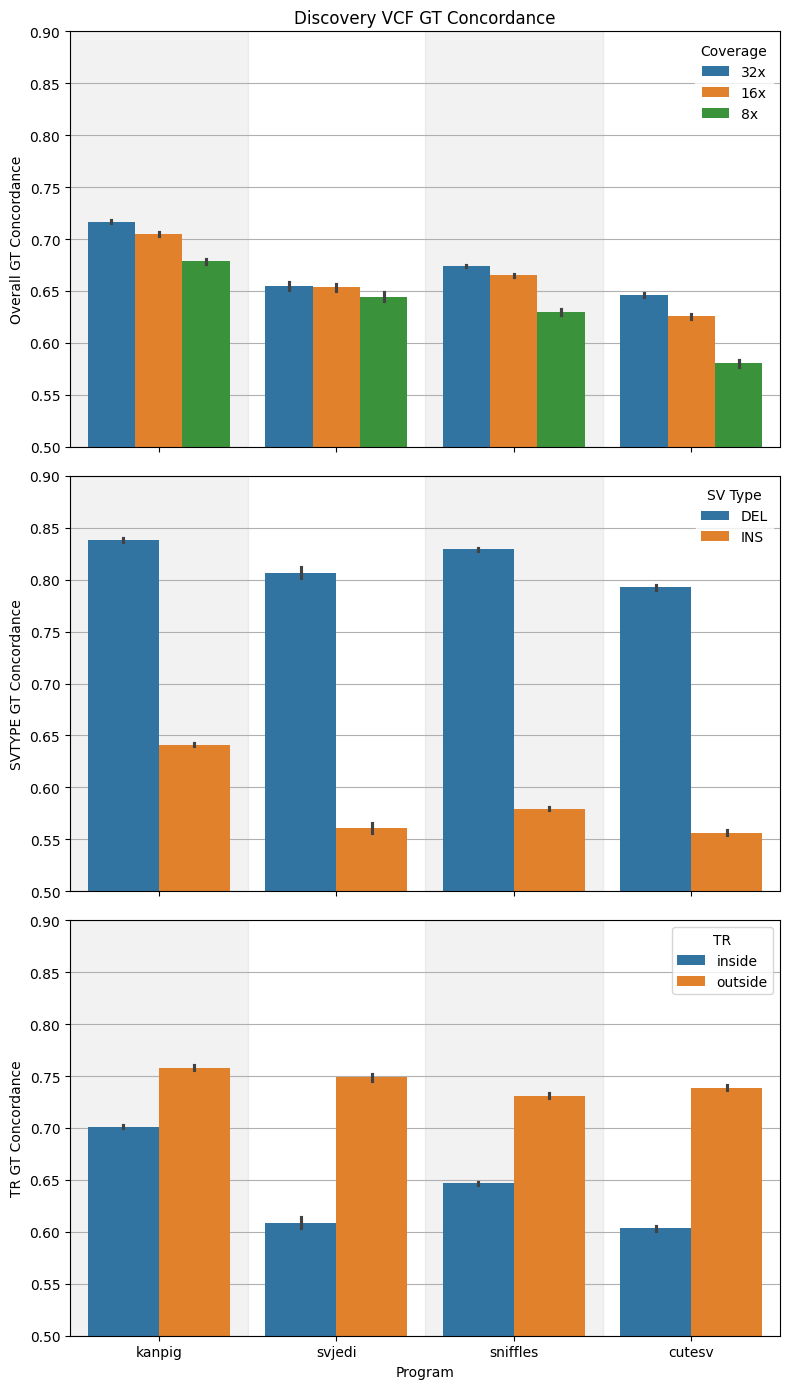

In [12]:
add_summary(svtype_data)
add_summary(tr_svtype_data)
add_summary(ntr_svtype_data)

exp = 'ds'

view = svtype_data[(svtype_data['svtype'] == 'TOT')
                    & (svtype_data['experiment'] == exp)
                    & (svtype_data['technology'] == 'pac')]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8, 14))

plot_gtconcordance_barplot(view, ax1, "Discovery VCF GT Concordance")

a = svtype_data[(tr_svtype_data['svtype'] != 'TOT')
                   & (svtype_data['experiment'] == exp)
                   & (svtype_data['technology'] == 'pac')
                   & (svtype_data['coverage'] == '32x')]

b = tr_svtype_data[(tr_svtype_data['svtype'] == 'TOT')
                   & (tr_svtype_data['experiment'] == exp)
                   & (tr_svtype_data['technology'] == 'pac')
                   & (tr_svtype_data['coverage'] == '32x')].copy()
b['TR'] = 'inside'
c = ntr_svtype_data[(ntr_svtype_data['svtype'] == 'TOT')
                   & (ntr_svtype_data['experiment'] == exp)
                   & (ntr_svtype_data['technology'] == 'pac')
                   & (ntr_svtype_data['coverage'] == '32x')].copy()
c['TR'] = 'outside'
d = pd.concat([b, c]).reset_index(drop=True)

plot_typestrat(a, d, ax2, ax3)
fig.tight_layout()
plt.show()
